In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from modules.forecasting.data.preprocess_coin import CoinPreprocessor  
from modules.forecasting.data.preprocess_panel import PanelPreprocessor  

PROPHET_BASE_DIR = Path(r"D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\prophet")
SARIMAX_BASE_DIR = Path(r"D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\sarimax")
TFT_BASE_DIR = Path(r"D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\tft")
CNNLSTM_BASE_DIR = Path(r"D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\cnn-lstm")

SYMBOL = "BTC"  
EXCHANGE = "binance"
INTERVAL = "1h"
FORECAST_STEPS = 168  

In [3]:
coin_pre = CoinPreprocessor() 

df_recent = coin_pre.load_features_series(SYMBOL, exchange=EXCHANGE, interval=INTERVAL)
df_recent = df_recent.tail(1000).copy() 

if 'symbol' not in df_recent.columns:
    df_recent['symbol'] = SYMBOL
if 'time' not in df_recent.columns:
    df_recent['time'] = df_recent.index

print(f"Loaded recent data shape: {df_recent.shape}")
print(df_recent.tail())

Loaded recent data shape: (1000, 25)
                          symbol exchange interval      open      high  \
time                                                                     
2025-09-25 00:00:00+00:00    BTC  binance       1h  0.916754  0.909538   
2025-09-26 00:00:00+00:00    BTC  binance       1h  0.880851  0.883050   
2025-09-27 00:00:00+00:00    BTC  binance       1h  0.886254  0.878462   
2025-09-28 00:00:00+00:00    BTC  binance       1h  0.886191  0.899965   
2025-09-29 00:00:00+00:00    BTC  binance       1h  0.907238  0.915490   

                                low     close    volume   returns  close_lag1  \
time                                                                            
2025-09-25 00:00:00+00:00  0.911378  0.880850  0.027618  0.575729   113307.00   
2025-09-26 00:00:00+00:00  0.911279  0.886253  0.018429  0.646713   108994.49   
2025-09-27 00:00:00+00:00  0.915106  0.886190  0.006935  0.636999   109643.46   
2025-09-28 00:00:00+00:00  0.916188  0.

Loaded Prophet model from D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\prophet\prophet_BTC.pkl
Prophet Forecast:
2025-09-29 01:00:00+00:00    103.822204
2025-09-29 02:00:00+00:00    104.011632
2025-09-29 03:00:00+00:00    104.133037
2025-09-29 04:00:00+00:00    104.223861
2025-09-29 05:00:00+00:00    104.307057
2025-09-29 06:00:00+00:00    104.381360
2025-09-29 07:00:00+00:00    104.442780
2025-09-29 08:00:00+00:00    104.509809
2025-09-29 09:00:00+00:00    104.622934
2025-09-29 10:00:00+00:00    104.816946
Freq: h, Name: yhat, dtype: float64
2025-10-05 15:00:00+00:00    131.242650
2025-10-05 16:00:00+00:00    131.477102
2025-10-05 17:00:00+00:00    131.649442
2025-10-05 18:00:00+00:00    131.738914
2025-10-05 19:00:00+00:00    131.756426
2025-10-05 20:00:00+00:00    131.759410
2025-10-05 21:00:00+00:00    131.827618
2025-10-05 22:00:00+00:00    132.012320
2025-10-05 23:00:00+00:00    132.299316
2025-10-06 00:00:00+00:00    132.618056
Freq: h, Name:

c:\Users\sarfras\anaconda3\envs\crypto\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\prophet.py:73: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start_date = last_date + pd.to_timedelta(1, unit=freq)
D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\prophet.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_future.index = pd.date_range(
C:\Users\sarfras\AppData\Local\Temp\ipykernel_19796\4243810402.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq='H')


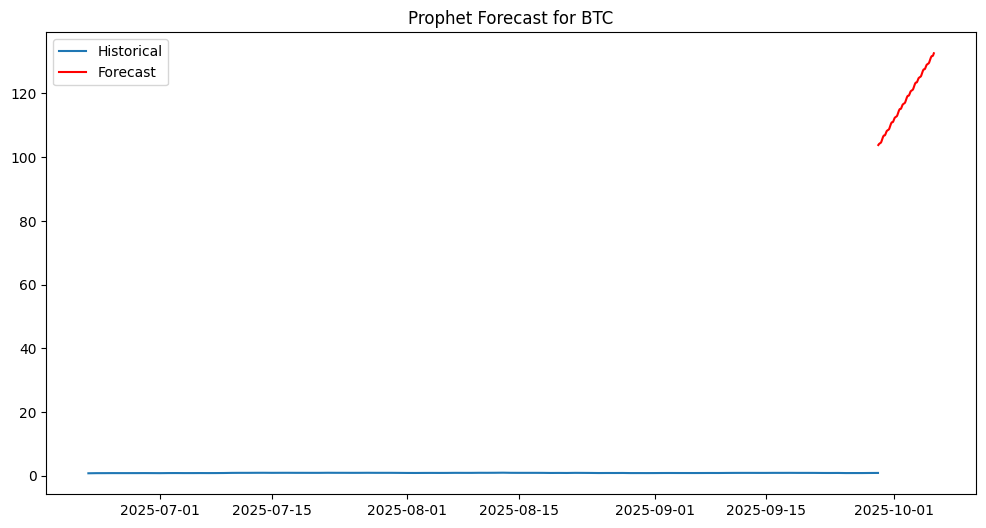

In [ ]:
from modules.forecasting.models.prophet import ProphetModel  

promodel = ProphetModel(
    symbol=SYMBOL,
    model_dir=str(PROPHET_BASE_DIR),
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_range=0.8
)

promodel_path = PROPHET_BASE_DIR / f"prophet_{SYMBOL}.pkl"
if promodel_path.exists():
    promodel.load()
    print(f"Loaded Prophet model from {promodel_path}")
else:
    print("No saved model found. Training a new one...")
    promodel.train(df_recent, target_col='close')
    promodel.save()
    print(f"Trained and saved new Prophet model to {promodel_path}")

last_date = df_recent.index[-1]
forecast = promodel.forecast(steps=FORECAST_STEPS, last_date=last_date, freq='H')

print("Prophet Forecast:")
print(forecast.head(10))  
print(forecast.tail(10)) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_recent.index[-100:], df_recent['close'].tail(100), label='Historical')
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq='H')
plt.plot(future_dates, forecast.values, label='Forecast', color='red')
plt.legend()
plt.title(f'Prophet Forecast for {SYMBOL}')
plt.show()

Loaded SARIMAX model from D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\saved\sarimax\sarimax_BTC.pkl
SARIMAX Forecast:
2025-09-29 01:00:00+00:00    102.259924
2025-09-29 02:00:00+00:00    102.247367
2025-09-29 03:00:00+00:00    102.241511
2025-09-29 04:00:00+00:00    102.238781
2025-09-29 05:00:00+00:00    102.237507
2025-09-29 06:00:00+00:00    102.236913
2025-09-29 07:00:00+00:00    102.236637
2025-09-29 08:00:00+00:00    102.236507
2025-09-29 09:00:00+00:00    102.236447
2025-09-29 10:00:00+00:00    102.236419
Freq: h, Name: predicted_mean, dtype: float64
2025-10-05 15:00:00+00:00    102.236395
2025-10-05 16:00:00+00:00    102.236395
2025-10-05 17:00:00+00:00    102.236395
2025-10-05 18:00:00+00:00    102.236395
2025-10-05 19:00:00+00:00    102.236395
2025-10-05 20:00:00+00:00    102.236395
2025-10-05 21:00:00+00:00    102.236395
2025-10-05 22:00:00+00:00    102.236395
2025-10-05 23:00:00+00:00    102.236395
2025-10-06 00:00:00+00:00    102.236395
Freq

D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\sarimax.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start_date = last_date + pd.to_timedelta(1, unit=freq)
D:\python_projects\crypto-analytics-platform\src\modules\forecasting\models\sarimax.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast.index = pd.date_range(
C:\Users\sarfras\AppData\Local\Temp\ipykernel_19796\1565562741.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq='H')


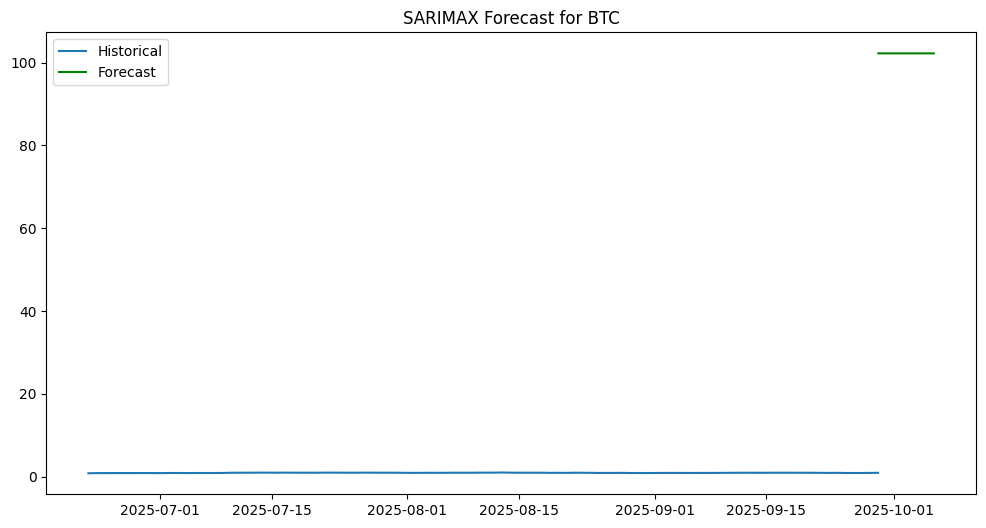

In [6]:
from modules.forecasting.models.sarimax import SarimaxModel 

sarimodel = SarimaxModel(
    symbol=SYMBOL,
    order=(1, 1, 1), 
    seasonal_order=(0, 0, 0, 0),
    model_dir=str(SARIMAX_BASE_DIR)
)

sarimodel_path = SARIMAX_BASE_DIR / f"sarimax_{SYMBOL}.pkl"
if sarimodel_path.exists():
    sarimodel.load()
    print(f"Loaded SARIMAX model from {sarimodel_path}")
else:
    print("No saved model found. Training a new one...")
    sarimodel.train(df_recent, target_col='close')
    sarimodel.save()
    print(f"Trained and saved new SARIMAX model to {sarimodel_path}")

last_date = df_recent.index[-1]
forecast = sarimodel.forecast(steps=FORECAST_STEPS, last_date=last_date, freq='H')

print("SARIMAX Forecast:")
print(forecast.head(10))
print(forecast.tail(10))

plt.figure(figsize=(12, 6))
plt.plot(df_recent.index[-100:], df_recent['close'].tail(100), label='Historical')
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq='H')
plt.plot(future_dates, forecast.values, label='Forecast', color='green')
plt.legend()
plt.title(f'SARIMAX Forecast for {SYMBOL}')
plt.show()